**Previous book**: <a href='./03_topic_modelling.ipynb'>[Topic Modelling]</a>

## Part 4: Article Similarity
**NOTE**: This notebook expects <code>vector_articles.csv</code> from the <code>01_intro_and_vectorization.ipynb</code> notebook and <code>03_named_clustered_df.csv</code> from <code>03_topic_modelling.ipynb</code> notebook.

In this part of the project, we calculate the pairwise similarity between articles. We will then use this information to construct a graph using Networkx where nodes are articles, and edges connect those with similarity over a certain threshold. We will examine which threshold best fits the data, and then visualise the completed topic map.

**Input:** <code>../data/models/svd_matrix.npy</code> and <code>../data/interrim/03_named_clustered_df.csv</code>

**Output:** <code>../data/final/clustered_neighbours_df.csv</code> and <code>../data/models/full_graph.gpickle</code>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from itertools import combinations
import pickle


svd_matrix = np.load("../data/models/svd_matrix.npy")
full_df = pd.read_csv("../data/interrim/03_named_clustered_df.csv")

# "clusters" was originally created as an array in part 2:
clusters = full_df["Cluster"]
# Extract titles and colours as arrays for creating graph:
titles = full_df["Title"]
colours = full_df["Colour"]
# other important metrics:
views = full_df["Views"]
topics = full_df["Topic"]


### Cosine similarity
A common method of measuring the similarity between two vectorized articles is cosine similarity. This metric calculates the angle between two vectors. The cosine of the angle gives the cosine similarity which ranges from -1 to 1. A cosine similarity score of 1 indicates that there is no difference between two articles (the angle between them is zero). Conversely,  a score of -1 indicates that the articles are completely opposite to each other (the angle between them is 180 degrees). Two articles with a cosine similarity score of zero are considered to have no similarity (the vectors are perpendicular).


The cosine similarity for the articles will be calculated from the SVD matrix, the same matrix that was used for k-means clustering.


We will add the article title rather than the ID as the index. This makes it easy to judge if the articles are indeed similar.

In [2]:
svd_df_title = pd.DataFrame(svd_matrix, index=full_df["Title"])

Write a function that will return the top *n* articles of a given article based on the cosine similarity.

These similarities will be based only on the words (or SVD representations of words) used in an article (vector), with articles containing similar words being considered similar.

In [3]:
def get_similar_article(article_name, num_articles=15):
    
    article = svd_df_title.loc[article_name]
    similarities_cosine = cosine_similarity(svd_df_title, article.values.reshape(1, -1))
    data = {"Similarities": similarities_cosine.flatten(), "Cluster": clusters}
    similarities_df = pd.DataFrame(data, index=svd_df_title.index)
    similar_articles = similarities_df.nlargest(num_articles + 1 , "Similarities")[1:]
    
    return similar_articles

Call the function with an article:

In [4]:
get_similar_article("How to Perform the Tahajjud Prayer", 10)

,Similarities,Cluster
Title,,
How to Audition for TV Shows,0.543010,NaN
How to Make Your Dog Stop Sleeping in Your Bed,0.541488,NaN
How to Lucid Dream,0.495145,NaN
How to Become a Buddhist,0.457584,NaN
How to Do a 21 Card Card Trick,0.453821,NaN
How to Perform Astral Projection,0.449500,NaN
How to Attract a Cancer Man: Catching His Eye & Getting Him Like to You,0.442667,NaN
How to Celebrate Easter,0.433400,NaN
How to Handle a Cheating Partner,0.432627,NaN


Based on the titles, the first article in the dataset, <i>How to Perform the Tahajjud Prayer</i>, does not really have any similar articles. The 2 articles with the highest similarities, while in the same cluster, are about very different subjects. This suggests that this article is rather distinct from all other articles in the dataset, and for the purposes of this analysis, a cosine similarity of < 0.544 suggests only a distant relation.

Checking the next article:

In [5]:
get_similar_article("How to Take a Screenshot on a Windows PC: 8 Simple Tricks", 10)

,Similarities,Cluster
Title,,
How to Take a Screenshot on a Mac: Complete Guide,0.918188,NaN
"How to Print Screen on an HP Laptop, Desktop, or Tablet",0.819119,NaN
10 Easy Ways to Take a Screenshot with a MacBook,0.792809,NaN
5 Simple Ways to Open the Command Prompt in Windows,0.755202,NaN
"Rotating Your Screen on Windows, Chromebook, iOS, & More",0.709669,NaN
How to Connect a Laptop to a Monitor,0.693768,NaN
How to Switch Tabs in Chrome,0.659134,NaN
How to Check Your Windows Version,0.658841,NaN
3 Simple Ways to Insert a Hyperlink in Microsoft Word,0.653629,NaN


In [6]:
get_similar_article("How to Stop Being an Oversharer in Person and on Social Media", 10)

,Similarities,Cluster
Title,,
How to Mingle With Strangers at Parties,0.810688,NaN
How to Talk to Your Girlfriend on the Phone,0.766331,NaN
How to Keep the Conversation Flowing with a Girl (for Guys),0.764971,NaN
How to Flirt,0.752561,NaN
How to Comfort Someone Who Is Sad,0.733051,NaN
"19 Tips to Have a Fun, Interesting Text Conversation",0.722702,NaN
How to Chat with a Girl on Facebook,0.721501,NaN
How to Recognize That You Have a Crush on Someone,0.718493,NaN
How to Get a Girl to Like You,0.716974,NaN


**0.7** is a sensible similarity threshold. The ensures that related articles are connected, without forming too many connections. This value can be tweaked to balance sparcity and informity.

### Topic map

We will now create the topic map using Networkx.

It is easier to create graphs with numerical rather than text node names, so first we will modify the <code>svd_df</code> to use the article ID as the index:

In [7]:
svd_df = pd.DataFrame(svd_matrix, index=full_df["Article_Id"])

First create an empty graph object, <code>G</code> and assign each article in the dataset as a node in the graph as part of a loop.

We can make use of the <code>enumerate</code> and node attributes to look up the title and which cluster each article belongs to, and add them as a characteristics of the node.

In [8]:
G = nx.Graph()
graph_topics = svd_df.index
node_attributes = []
for index, node in enumerate(graph_topics):
    # name attributes, "color" to be recognized by Pyvis
    node_attributes.append((node, {"title": titles[index],
                                   "cluster": int(clusters[index]),
                                   "color": colours[index],
                                   "views": int(views[index]),
                                    "topic": topics[index]}))
G.add_nodes_from(node_attributes)

Checking the first article has the correct attributes:

In [9]:
G.nodes[1]

{'title': 'How to Perform the Tahajjud Prayer',
 'cluster': 3,
 'color': '#E05D5E',
 'views': 5638718,
 'topic': 'Emotions and Social'}

#### Determining the threshold

After creating the nodes, it is time to join them together with edges if they are similar. We will do this by comparing every possible combination of nodes, and if their cosine similarity exceeds the threshold, we will draw an edge between them.

How can we determine the threshold? Previously, we decided on 0.7 as a good balance, but we can calculate how connect the graph will be for a range of values (between 0.5 and 0.9).

We can use <code>combinations</code> from <code>itertools</code> to calculate the cosine similarity between each pair of nodes. First we calculate the pairs with the minimum level, then we can filter this list for each value.

In [10]:
minimum_threshold = 0.5
potential_edges = []

for n1, n2 in combinations(svd_df.index, 2):
    vec1 = svd_df.loc[n1].values.reshape(1, -1)
    vec2 = svd_df.loc[n2].values.reshape(1, -1)
    cosine_score = cosine_similarity(vec1, vec2)[0, 0]

    if cosine_score > minimum_threshold:
        potential_edges.append((n1, n2, cosine_score))

This allow us to avoid re-running itertools, a computionally expensive operation, every time we want to recalculate the threshold.

We can calculate the graph density for each threshold value. This is a measure of how connected a graph is as a rato between current edges and the maximum possible edges.

Try for a range of treshold values:

In [11]:
threshold_values = [0.5, 0.6, 0.7, 0.8, 0.9]
number_of_nodes = len(G.nodes())

edges_list = []
density_list = []

for threshold in threshold_values:
    filtered_edges = [(n1, n2, score) for (n1, n2, score) in potential_edges if score >= threshold]
    number_of_edges = len(filtered_edges)
    
    # Density is equal to 2m/n(n-1) where m is edges and n is nodes
    density = (2 * number_of_edges)/ (number_of_nodes * (number_of_nodes - 1))
    edges_list.append(number_of_edges)
    density_list.append(density)

graph_dict = {"threshold": threshold_values, "edges": edges_list, "density": density_list}

summary_df = pd.DataFrame.from_dict(graph_dict)
summary_df

,threshold,edges,density
0,0.5,8366,0.016850
1,0.6,3823,0.007700
2,0.7,1651,0.003325
3,0.8,729,0.001468
4,0.9,164,0.000330


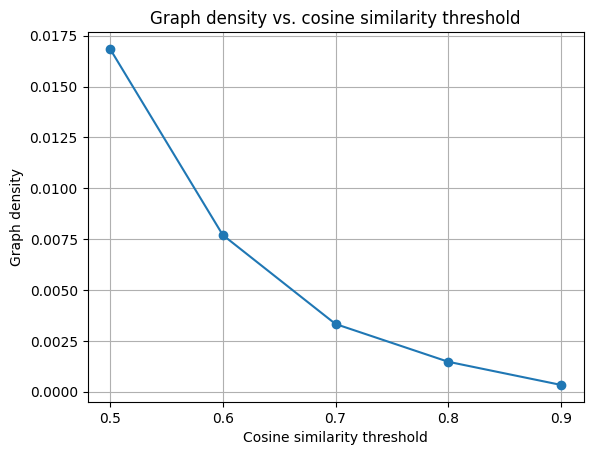

In [12]:
fig, ax = plt.subplots()
    
ax.plot(summary_df["threshold"], summary_df["density"], '-o')
ax.set(
        title="Graph density vs. cosine similarity threshold",
        xlabel="Cosine similarity threshold",
        ylabel="Graph density",
        xticks=summary_df["threshold"]
      )
ax.grid()
plt.show()

From the above plot, we can see that 0.7 was indeed a good balance for threshold. We can use this value for cosine similarty.

We can also assign a value to indicate how similar two articles are as an attribute of the edge. This allows us to distinguish between heavily similar articles and articles whose cosine similarity just pass the threshold value. 

In [13]:
current_edges = [(n1, n2, score) for (n1, n2, score) in potential_edges if score >= 0.7]

for n1, n2, score in current_edges:
    score = float(score)
    if n1 in G.nodes() and n2 in G.nodes():
        G.add_edge(n1, n2, weight=score)

Finally, we can count the number of edges each node (article) has. This is known as the **degree** of a node, and represents how many articles it directly connects to. In network analysis, degree is a simple way of measuring the importance or centrality of a node. Articles with a high degree are more connected and may play a more central role in the graph.

In our analysis of articles and topics, this has a slightly different meaning. If an article shares a significant amount of its vocabulary with a lot of other articles, this may mean that the article is covering the same information and could be redundant.

Removing such articles is important to streamlining a corpus. This can improve user experience by optimizing help documentation and refining search results. It can also be used to prepare high quality input for large language models.

Add the number of neighbours each node has to the original dataframe:

In [14]:
node_neighbors = []
for node in G.nodes():
    neighbours = len(list(G.neighbors(node)))
    node_neighbors.append(neighbours)

full_df["Neighbours"] = node_neighbors

Are well connected articles more popular?

In [15]:
full_df["Neighbours"].corr(full_df["Views"]).round(2)

0.06

Popularity and number of neighbours are not related.

Which clusters have the most neighbours?

In [16]:
full_df.groupby("Cluster")["Neighbours"].agg(["mean", "median", "std"])

,mean,median,std
Cluster,,,
0,1.106299,0.0,1.642001
1,3.411765,1.0,4.807442
2,1.858921,1.0,2.756208
3,3.017045,2.0,3.454975
4,25.131579,30.0,10.710366
5,2.733333,2.0,2.623658
6,5.717647,2.0,6.514840


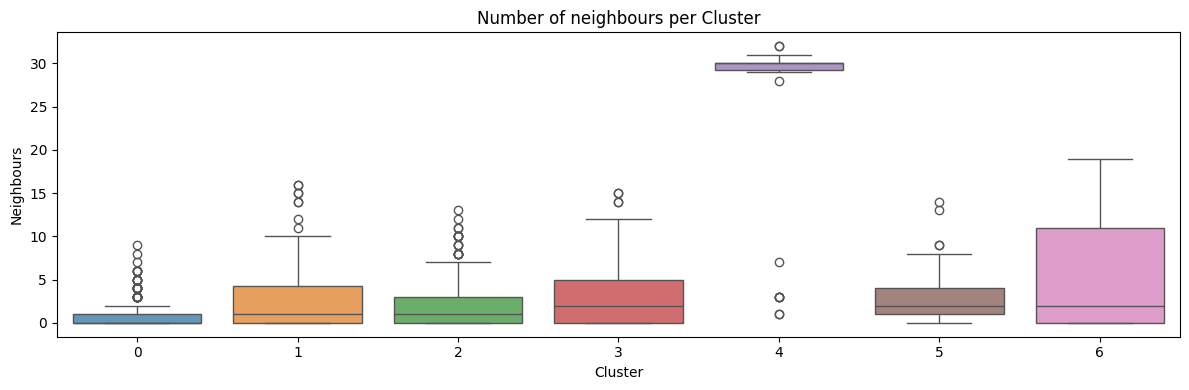

In [17]:
cluster_colours = ["#5799C6", "#FE9E4B", "#60B961", "#E05D5E", "#AF8CCC", "#A87F77", "#E992CE"]
clusters_sorted = sorted(full_df["Cluster"].unique())
cluster_palette = dict(zip(clusters_sorted, cluster_colours))

plt.figure(figsize=(12, 4))
sns.boxplot(data=full_df, x="Cluster", y="Neighbours", hue="Cluster", legend=False, palette=cluster_palette)

plt.title('Number of neighbours per Cluster')
plt.xlabel("Cluster")
plt.ylabel("Neighbours")
plt.tight_layout()
plt.show()

The cluster with the most connected articles is Cluster 5. This is also the cluster with the lowest interia. The article with the least number of neighbours is Cluster 0, the cluster with the highest inerita. Cluster 5 has a well-defined topic and articles in this cluster probably share a lot of vocabulary, and as such, have high cosine similarity. The opposite is true for Cluster 0.

#### Overview of the full topic map

Now that the nodes and edges have been created, we can visualize the complete topic map. To better do this, we will remove the nodes with no connections. This will result in a more focused topic map.


However, these nodes are still informative in other ways, so we must copy the graph before making changes:

In [18]:
J = G.copy()

Remove the non-connected nodes for simplicity:

In [19]:
low_degree = [n for n, d in G.degree() if d < 1]
G.remove_nodes_from(low_degree)

Display the pruned graph.

**Note**: It is difficult to read such a large graph, but we can see the basic structure.

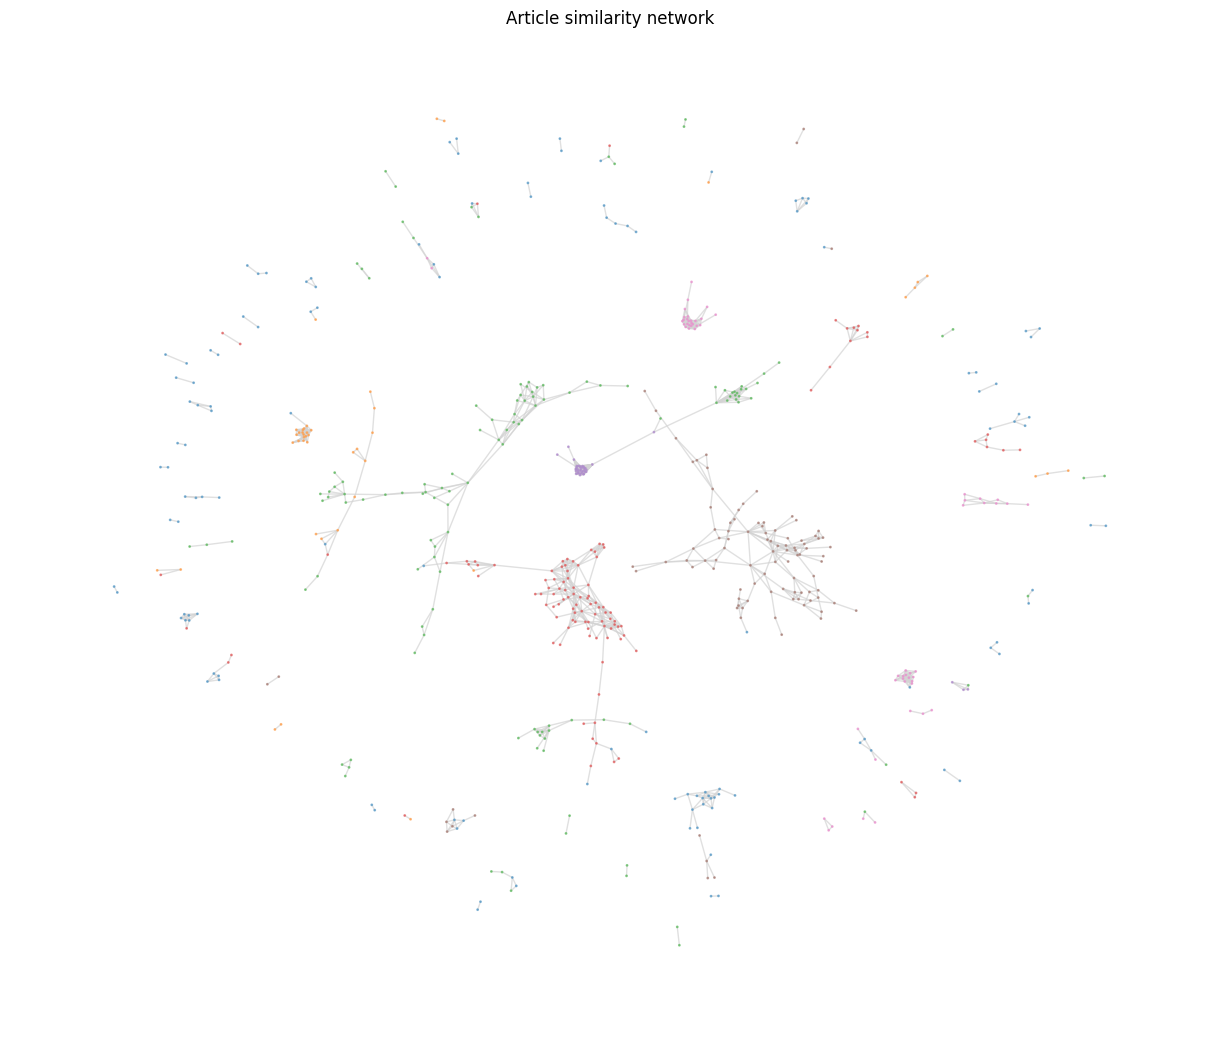

In [20]:
pos = nx.spring_layout(G, seed=2)

plt.figure(figsize=(12, 10))
node_colours = [data["color"] for _, data in G.nodes(data=True)]

nx.draw(
    G, pos, with_labels=False, node_size=1, node_color=node_colours, alpha=0.7, edge_color="lightgray")


plt.title("Article similarity network")
plt.axis('off')
plt.show()

Visually, we can see some large subgraphs of mainly one colour, representing articles that were clustered together. We can also see a lot of two-node cliques and other small subgraphs. Notably Cluster 4, **Haircare**, seems like a very connected subgraph that appears to contain the majority of articles in that cluster.

There also appears to be some subgraphs made up of mainly articles from one cluster, but one or two articles from a different one. This suggests that may be some articles were incorrectly clustered. These mixed subgraphs should be investigated further.

This topic map is also consistent with the t-SNE visualization from part 2. We can see good connections between some clusters, such as Cluster 3 (red), Cluster 2 (green) and especially Cluster 4 (pink) which are also visible in the t-SNE visualization. Also, Cluster 0 (blue) does not appear to have a large subgraph and is mostly made up of smaller subgraphs of 2 or more nodes. This suggests that Cluster 0 fills the role of a miscellaneous category, taking any article that does not fit well into other clusters. 

Looking at basic metrics of the pruned topic map:

In [21]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Density:", round(nx.density(G), 3))
print("Is connected:", nx.is_connected(G))

Number of nodes: 612
Number of edges: 1651
Density: 0.009
Is connected: False


The density of the main graph is very sparse. Less than 1% of possible edges actually exist. This is typical of large semantic networks where most articles are not similar enough to have an edge, and tend to form smaller connected subgraphs.

In the next part, we will look more closely at a connected subgraph.

### Summary

In this chapter, we:

<ul>
    <li>Calculated the cosine similarity between all pairs of articles.</li>
    <li>Investigated what cosine similarity threshold resulted in the most informative graph.</li>
    <li>Used Networkx to construct a graph and examined the basic structure of the network</li>
</ul>


Prepare the dataframe and graph pickle for the next notebook:

In [22]:
full_df.to_csv("../data/interrim/04_clustered_neighbours_df.csv", index=False)

with open("../data/models/full_graph.gpickle", "wb") as f:
    pickle.dump(J, f)

### Navigation
**Previous book**: <a href='./03_topic_modelling.ipynb'>[Topic Modelling]</a>

**Next book**: <a href='./05_network_analysis.ipynb'>[Network Analysis]</a>